# Exploring transcribed data

In [1]:
import os
import glob
import re
import io
from PIL import Image
from panoptes_client import Panoptes, Project, SubjectSet, Subject
from panoptes_client.exportable import Exportable
from credentials import ZOONIVERSE_USER, ZOONIVERSE_PW
import pandas as pd
from pandas.io.json import json_normalize
import json
import arrow

## Get transcribed data from Zooniverse

In [2]:
Panoptes.connect(username=ZOONIVERSE_USER, password=ZOONIVERSE_PW)

Should add a step here to generate a new report.

In [3]:
classification_export = Project(8678).get_export('classifications')

In [4]:
df = pd.read_csv(io.BytesIO(classification_export.content))
df.head()

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,152228384,wragge,299993,f56860099175406887f7,9738,Transcribe,5.60,2019-03-13 06:24:43 UTC,NaN,NaN,"{""source"":""api"",""session"":""e0d698612e971be2c63...","[{""task"":""T0"",""value"":""Potters Sulphide Ore Tr...","{""31216279"":{""retired"":null,""row"":""32"",""page"":...",31216279
1,152456334,wragge,299993,0d91b037230b486aa157,9738,Transcribe,10.80,2019-03-14 01:20:18 UTC,NaN,NaN,"{""source"":""api"",""session"":""4f36768a74d53502e38...","[{""task"":""T0"",""value"":"""",""task_label"":""What's ...","{""31216275"":{""retired"":null,""row"":""29"",""page"":...",31216275
2,174876307,wragge,299993,29287f669dd4ade1c4fb,11577,Transcribe dates,23.25,2019-07-17 07:19:39 UTC,NaN,NaN,"{""source"":""api"",""session"":""f9ba2ebc36b589350fc...","[{""task"":""T0"",""task_label"":""Session?"",""value"":...","{""35123970"":{""retired"":null,""year"":1929,""image...",35123970
3,174876535,wragge,299993,29287f669dd4ade1c4fb,11577,Transcribe dates,27.27,2019-07-17 07:22:44 UTC,NaN,NaN,"{""source"":""api"",""session"":""23df4ddbc2756f8ab3d...","[{""task"":""T4"",""task_label"":""Can you see a date...","{""35124669"":{""retired"":null,""year"":1929,""image...",35124669
4,174876842,wragge,299993,29287f669dd4ade1c4fb,11577,Transcribe dates,45.45,2019-07-17 07:26:17 UTC,NaN,NaN,"{""source"":""api"",""session"":""54ade2eb34a577ebae4...","[{""task"":""T4"",""task_label"":""Can you see a date...","{""35125039"":{""retired"":null,""year"":1929,""image...",35125039


The `annotations` and `subjects` data is nested.

In [5]:
json.loads(df.loc[df['workflow_id'] == 11577].iloc[10]['annotations'])

[{'task': 'T4',
  'task_label': 'Can you see a handwritten date?',
  'value': 'Yes'},
 {'task': 'T0',
  'task_label': 'Can you identify the session? Look for one of the following handwritten headings.',
  'value': 'No session heading'},
 {'task': 'T5',
  'task_label': 'What is the day of the week?',
  'value': 'Saturday'},
 {'task': 'T1',
  'value': '29',
  'task_label': 'What is the day of the month? This should be a number between 1 and 31.'},
 {'task': 'T2', 'task_label': 'What is the month?', 'value': 'June'},
 {'task': 'T3', 'value': '1929', 'task_label': 'What is the year?'}]

## Flatten nested data

In [6]:
def list_of_dicts(ld):
    '''
    Create a mapping of the tuples formed after 
    converting json strings of list to a python list   
    '''
    return dict([(d['task'], d['value']) for d in json.loads(ld)])

annotations = json_normalize(df['annotations'].apply(list_of_dicts).to_list())
subjects = json_normalize(df['subject_data'].apply(lambda x: list(json.loads(x).values())[0]).to_list())

In [7]:
annotations.head()

,T0,T1,T2,T3,T4,T5
0,Potters Sulphide Ore Treatm't,NaN,NaN,NaN,NaN,NaN
1,,,,,NaN,NaN
2,Morning,12,NaN,NaN,NaN,NaN
3,Morning,14,January,1929,Yes,NaN
4,Noon,3,May,1929,Yes,NaN


In [8]:
subjects.head()

,column,image,page,page_number,retired,row,volume,volume_number,year
0,2,N193-022_0184-col-2-32.jpg,0184,NaN,None,32,N193-022,NaN,NaN
1,2,N193-022_0184-col-2-29.jpg,0184,NaN,None,29,N193-022,NaN,NaN
2,NaN,N193-115_0158-header.jpg,NaN,158.0,None,NaN,N193-115,115.0,1929.0
3,NaN,N193-113_0028-header.jpg,NaN,28.0,None,NaN,N193-113,113.0,1929.0
4,NaN,N193-114_0110-header.jpg,NaN,110.0,None,NaN,N193-114,114.0,1929.0


In [9]:
df_expanded = df[['user_name', 'user_id', 'workflow_id', 'workflow_name', 'created_at', 'gold_standard', 'expert', 'subject_ids']].join([annotations, subjects])

In [10]:
df_headers = df_expanded.loc[df_expanded['workflow_id'] == 11577]

In [11]:
df_headers.head()

,user_name,user_id,workflow_id,workflow_name,created_at,gold_standard,expert,subject_ids,T0,T1,...,T5,column,image,page,page_number,retired,row,volume,volume_number,year
2,wragge,299993,11577,Transcribe dates,2019-07-17 07:19:39 UTC,NaN,NaN,35123970,Morning,12,...,NaN,NaN,N193-115_0158-header.jpg,NaN,158.0,None,NaN,N193-115,115.0,1929.0
3,wragge,299993,11577,Transcribe dates,2019-07-17 07:22:44 UTC,NaN,NaN,35124669,Morning,14,...,NaN,NaN,N193-113_0028-header.jpg,NaN,28.0,None,NaN,N193-113,113.0,1929.0
4,wragge,299993,11577,Transcribe dates,2019-07-17 07:26:17 UTC,NaN,NaN,35125039,Noon,3,...,NaN,NaN,N193-114_0110-header.jpg,NaN,110.0,None,NaN,N193-114,114.0,1929.0
5,wragge,299993,11577,Transcribe dates,2019-07-22 23:46:08 UTC,NaN,NaN,35124594,Afternoon,8,...,NaN,NaN,N193-116_0149-header.jpg,NaN,149.0,None,NaN,N193-116,116.0,1929.0
6,wragge,299993,11577,Transcribe dates,2019-07-22 23:58:35 UTC,NaN,NaN,35123979,Noon,4,...,Monday,NaN,N193-116_0127-header.jpg,NaN,127.0,None,NaN,N193-116,116.0,1929.0


## Have a look at the data from a few different angles

In [12]:
df_headers['T0'].value_counts()

Afternoon             299
Noon                  282
Morning               135
No session heading     72
Name: T0, dtype: int64

In [13]:
df_headers['T1'].value_counts()

17                     31
10                     30
12                     30
11                     30
18                     28
4                      26
7                      23
9                      23
1                      23
5                      22
26                     22
20                     22
21                     22
29                     21
14                     20
15                     20
28                     20
8                      20
30                     19
6                      19
25                     18
27                     18
22                     18
23                     17
16                     16
3                      16
19                     15
2                      15
13                     14
24                     13
                       ..
26th                    9
2nd                     7
11th                    7
12th                    6
28th                    6
13th                    6
[unclear][/unclear]     5
10th        

In [14]:
df_headers['T2'].value_counts()

May          90
July         74
September    72
August       71
November     68
June         65
April        62
March        61
October      61
January      61
December     51
February     49
Name: T2, dtype: int64

In [15]:
df_headers['T3'].value_counts()

1929                   403
1930                   370
1989                     3
1919                     2
[unclear][/unclear]      1
1979                     1
12                       1
17                       1
1030                     1
1921                     1
1920                     1
Name: T3, dtype: int64

In [16]:
df_headers['T4'].value_counts()

Yes    787
No       1
Name: T4, dtype: int64

In [17]:
df_headers['T5'].value_counts()

Tuesday                 150
Friday                  149
Wednesday               143
Thursday                142
Monday                  127
Saturday                 71
Not given or unclear      1
Name: T5, dtype: int64

In [18]:
df_headers.shape

(797, 23)

In [19]:
# Filter columns

df_headers = df_headers[['user_name', 'created_at', 'subject_ids', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'image', 'year']]

## Normalisation of days

Remove ordinals from transcribed day values.

In [20]:
# I'm using .loc here to avoid the SetCopy warnings
# Note expand=False to return a series rather than a df
df_headers.loc[:, 'T1n'] = df_headers.loc[:, 'T1'].str.extract(r'(^\d+)', expand=False)

In [21]:
df_headers['T1n'].value_counts()

11    37
4     36
12    36
10    35
17    33
18    32
26    31
15    30
7     28
5     27
21    27
28    26
9     26
20    25
1     24
30    24
8     23
6     23
14    23
29    23
22    22
23    22
2     22
27    21
16    21
13    20
25    20
3     18
19    17
24    15
31    13
Name: T1n, dtype: int64

## Convert transcribed date parts into datetime objects

In [22]:
import datetime
import calendar
# T1n days
# T2 months
# T3 years

def create_date(row):
    # Convert month name into an index value between 1 and 12
    month = list(calendar.month_name).index(row['T2'])
    try:
        # Assemble datetime from the parts
        date = datetime.datetime(int(row['T3']), month, int(row['T1n']))
    except ValueError:
        date = None
    return date
    
df_headers.loc[:, 'date'] = df_headers.dropna(subset=['T1n', 'T2', 'T3']).apply(create_date, axis=1)

In [23]:
# Convert the column to a date type
# errors = 'coerce' will turn not date-like values into NaT
df_headers.loc[:, 'date'] = pd.to_datetime(df_headers.loc[:, 'date'], errors='coerce')

## Which transcriptions couldn't be converted into dates?

In [24]:
df_headers.loc[df_headers['date'].isnull()].style.applymap(lambda x: 'background-color: yellow', subset=pd.IndexSlice[:, ['T1', 'T2', 'T3']])

,user_name,created_at,subject_ids,T0,T1,T2,T3,T4,T5,image,year,T1n,date
2,wragge,2019-07-17 07:19:39 UTC,35123970,Morning,12,nan,nan,nan,nan,N193-115_0158-header.jpg,1929,12,NaT
142,Moegami,2019-08-16 00:59:37 UTC,35381824,nan,nan,nan,nan,No,nan,N193-120_0142-header.jpg,1930,nan,NaT
228,Walker.C,2019-08-16 02:05:45 UTC,35380988,nan,nan,nan,nan,None,nan,N193-119_0338-header.jpg,1930,nan,NaT
241,Walker.C,2019-08-16 02:09:23 UTC,35124292,Noon,[unclear][/unclear],October,1929,Yes,Tuesday,N193-116_0078-header.jpg,1929,nan,NaT
263,Walker.C,2019-08-16 02:21:38 UTC,35382123,Afternoon,nan,nan,nan,Yes,Tuesday,N193-117_0296-header.jpg,1930,nan,NaT
336,Walker.C,2019-08-16 02:50:38 UTC,35124942,nan,nan,nan,nan,None,nan,N193-115_0289-header.jpg,1929,nan,NaT
343,Walker.C,2019-08-16 02:53:36 UTC,35124053,Noon,[unclear][/unclear],July,1929,Yes,Tuesday,N193-115_0089-header.jpg,1929,nan,NaT
373,Moegami,2019-08-16 03:34:43 UTC,35124840,nan,nan,nan,nan,None,nan,N193-115_0219-header.jpg,1929,nan,NaT
375,Moegami,2019-08-16 03:35:18 UTC,35381766,nan,nan,nan,nan,None,nan,N193-117_0026-header.jpg,1930,nan,NaT
380,Moegami,2019-08-16 03:52:07 UTC,35125020,nan,nan,nan,nan,None,nan,N193-114_0191-header.jpg,1929,nan,NaT


## Do transcribed years match the year of the volume?

In [25]:
df_headers.loc[df_headers['T3'] != df_headers['year'].astype('int').astype('str')].style.applymap(lambda x: 'background-color: yellow', subset=pd.IndexSlice[:, ['T3','year']])

,user_name,created_at,subject_ids,T0,T1,T2,T3,T4,T5,image,year,T1n,date
2,wragge,2019-07-17 07:19:39 UTC,35123970,Morning,12,nan,nan,nan,nan,N193-115_0158-header.jpg,1929,12,NaT
142,Moegami,2019-08-16 00:59:37 UTC,35381824,nan,nan,nan,nan,No,nan,N193-120_0142-header.jpg,1930,nan,NaT
143,Moegami,2019-08-16 01:00:54 UTC,35124810,Afternoon,16,May,1919,Yes,Thursday,N193-114_0161-header.jpg,1929,16,1919-05-16 00:00:00
145,Moegami,2019-08-16 01:02:03 UTC,35124124,Noon,11,November,1989,Yes,Monday,N193-116_0154-header.jpg,1929,11,1989-11-11 00:00:00
148,Walker.C,2019-08-16 01:05:47 UTC,35124297,Afternoon,14,August,1920,Yes,Wednesday,N193-115_0171-header.jpg,1929,14,1920-08-14 00:00:00
152,Moegami,2019-08-16 01:10:24 UTC,35124926,Afternoon,16,August,1919,Yes,Friday,N193-115_0182-header.jpg,1929,16,1919-08-16 00:00:00
158,Moegami,2019-08-16 01:12:49 UTC,35123865,Noon,24,May,1989,Yes,Friday,N193-114_0192-header.jpg,1929,24,1989-05-24 00:00:00
161,Moegami,2019-08-16 01:15:19 UTC,35125138,No session heading,21,August,1979,Yes,Wednesday,N193-115_0196-header.jpg,1929,21,1979-08-21 00:00:00
185,Moegami,2019-08-16 01:31:18 UTC,35124329,Morning,24,October,1989,Yes,Thursday,N193-116_0087-header.jpg,1929,24,1989-10-24 00:00:00
228,Walker.C,2019-08-16 02:05:45 UTC,35380988,nan,nan,nan,nan,None,nan,N193-119_0338-header.jpg,1930,nan,NaT


## Check days of week match days of year

Do the transcribed values for days of the week match the date?

In [26]:
# A list of days of the week
days = list(calendar.day_name)

# Get transcriptions that have a date and a day of the week
df_days = df_headers.loc[(df_headers['date'].notnull()) & (df_headers['T5'].notnull()) & (df_headers['T5'] != 'Not given or unclear')]

In [27]:
# Show days where they don't match
df_days.loc[df_days.apply(lambda x: x['date'].dayofweek != days.index(x['T5']), axis=1)].style.applymap(lambda x: 'background-color: yellow', subset=pd.IndexSlice[:, ['T5','date']])

,user_name,created_at,subject_ids,T0,T1,T2,T3,T4,T5,image,year,T1n,date
116,ErinGallant,2019-07-29 02:33:26 UTC,35124664,Noon,31,May,1929,Yes,Thursday,N193-114_0219-header.jpg,1929,31,1929-05-31 00:00:00
143,Moegami,2019-08-16 01:00:54 UTC,35124810,Afternoon,16,May,1919,Yes,Thursday,N193-114_0161-header.jpg,1929,16,1919-05-16 00:00:00
145,Moegami,2019-08-16 01:02:03 UTC,35124124,Noon,11,November,1989,Yes,Monday,N193-116_0154-header.jpg,1929,11,1989-11-11 00:00:00
148,Walker.C,2019-08-16 01:05:47 UTC,35124297,Afternoon,14,August,1920,Yes,Wednesday,N193-115_0171-header.jpg,1929,14,1920-08-14 00:00:00
152,Moegami,2019-08-16 01:10:24 UTC,35124926,Afternoon,16,August,1919,Yes,Friday,N193-115_0182-header.jpg,1929,16,1919-08-16 00:00:00
158,Moegami,2019-08-16 01:12:49 UTC,35123865,Noon,24,May,1989,Yes,Friday,N193-114_0192-header.jpg,1929,24,1989-05-24 00:00:00
161,Moegami,2019-08-16 01:15:19 UTC,35125138,No session heading,21,August,1979,Yes,Wednesday,N193-115_0196-header.jpg,1929,21,1979-08-21 00:00:00
162,Walker.C,2019-08-16 01:16:15 UTC,35381789,Morning,17,February,1930,Yes,Thursday,N193-117_0198-header.jpg,1930,17,1930-02-17 00:00:00
185,Moegami,2019-08-16 01:31:18 UTC,35124329,Morning,24,October,1989,Yes,Thursday,N193-116_0087-header.jpg,1929,24,1989-10-24 00:00:00
330,Moegami,2019-08-16 02:49:12 UTC,35124177,No session heading,29th,July,1929,Yes,Saturday,N193-115_0107-header.jpg,1929,29,1929-07-29 00:00:00


In [28]:
datetime.datetime(1930, 8, 17).weekday()

6

In [29]:
days.index('Thursday')

3

## Visualise transcription results

In [30]:
from math import ceil

def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(ceil(adjusted_dom/7.0))

df_headers.loc[:, 'week'] = df_headers.loc[(df_headers['date'].notnull())].loc[:, 'date'].apply(week_of_month)

Remove duplicates (see below)

In [31]:
df_headers.drop_duplicates(subset=['image', 'date'], inplace=True)

In [32]:
import altair as alt
alt.renderers.enable('default')

RendererRegistry.enable('default')

In [33]:
pointer = alt.selection_single(fields=['date'])

color = alt.condition(pointer,
                      alt.Color('count():Q'),
                      alt.value('lightgray'))

year = alt.Chart(df_headers.loc[(df_headers['date'].notnull()) & (df_headers['date'].dt.year == 1929)]).mark_rect().encode(
    x=alt.X('day(date):O', title='day'),
    y='week:O',
    facet=alt.Facet('month(date):T', title=''),
    color=color,
    tooltip=['date:T', 'count():Q']
).properties(columns=4, title='1929').add_selection(pointer)

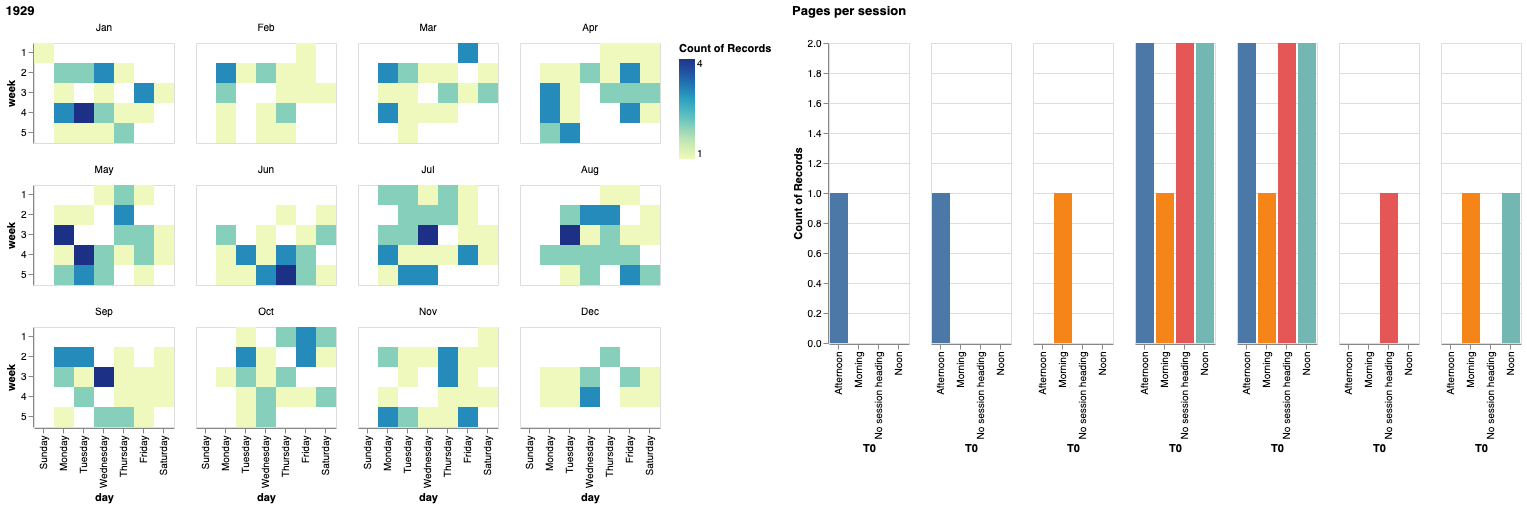

In [34]:
from altair import datum, expr
day = alt.Chart(df_headers.loc[(df_headers['date'].notnull())]).mark_bar().encode(
    x='T0:N',
    y='count():Q',
    color=alt.Color('T0:N', legend=None),
    tooltip=['date:T'],
    column=alt.Column('year(date):T', title=None, header=alt.Header(format=' '))
).transform_filter(pointer).properties(title='Pages per session')

text = alt.Chart(df_headers.loc[(df_headers['date'].notnull())]).mark_text().encode(
    text=alt.Text('min(date):N')
).transform_filter(pointer)

(year|day)


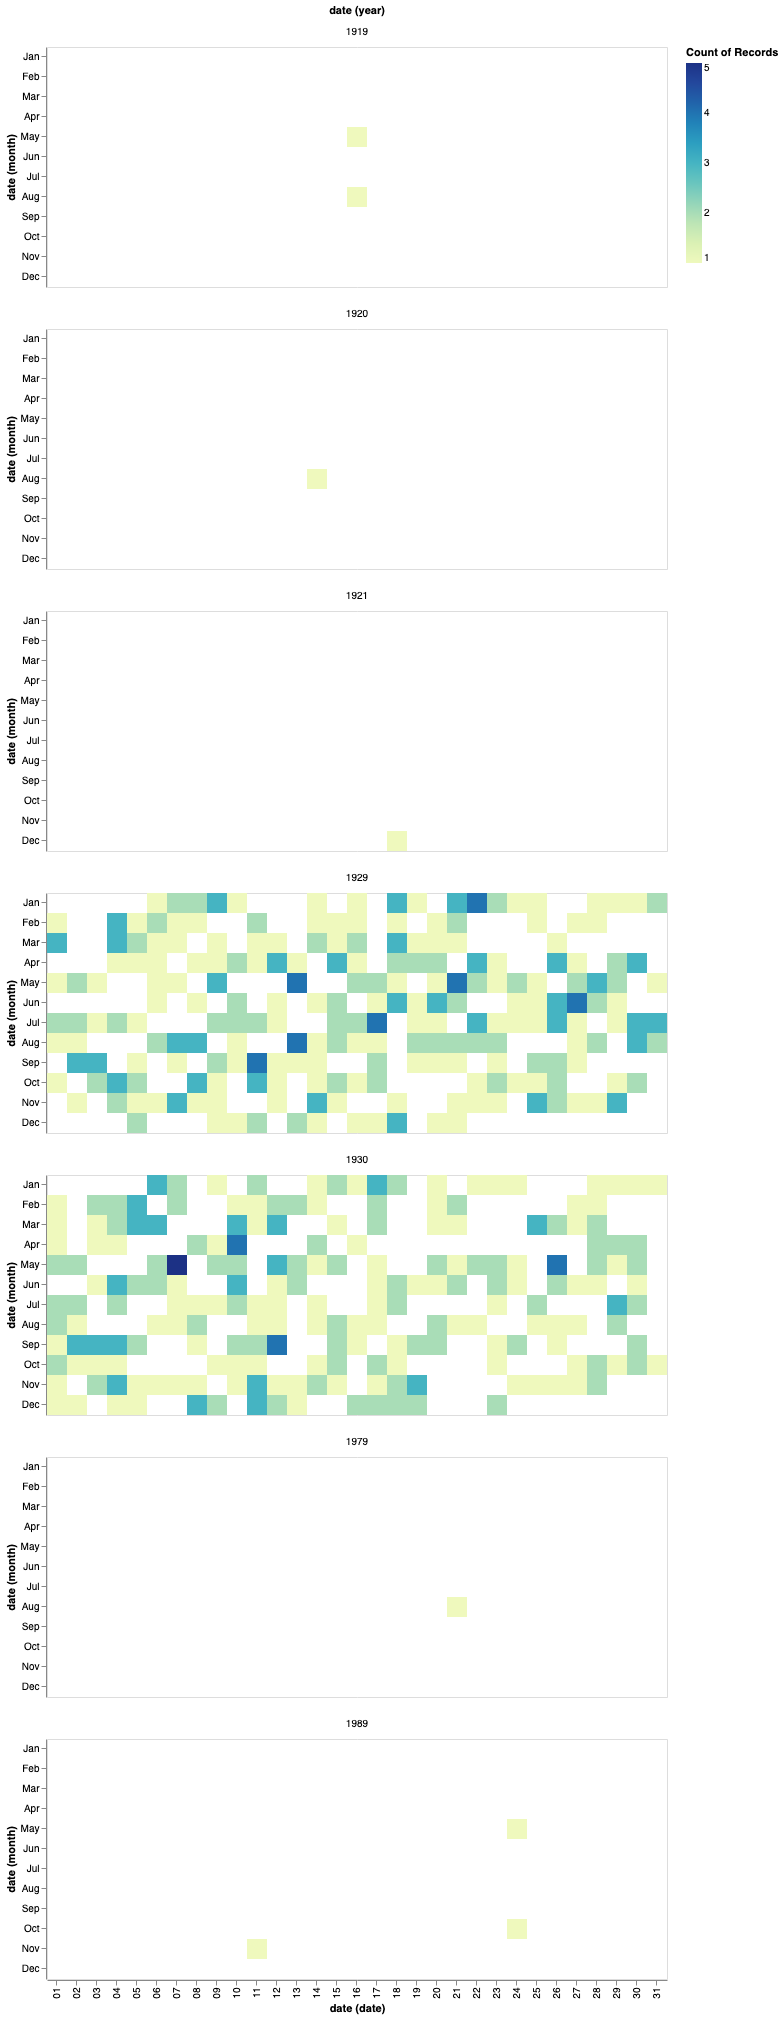

In [35]:
alt.Chart(df_headers.loc[(df_headers['date'].notnull())]).mark_rect().encode(
    x='date(date):O',
    y='month(date):O',
    color='count():Q',
    facet='year(date):O'
).properties(columns=1)

27 June 1929 has 3 afternoon pages, this seems odd. What's going on?

In [36]:
df_headers.loc[df_headers['date'] == '1929-06-27']

,user_name,created_at,subject_ids,T0,T1,T2,T3,T4,T5,image,year,T1n,date,week
305,Walker.C,2019-08-16 02:43:29 UTC,35124557,Afternoon,27,June,1929,Yes,Thursday,N193-114_0319-header.jpg,1929.0,27,1929-06-27,5.0
319,Walker.C,2019-08-16 02:46:31 UTC,35124097,Morning,27,June,1929,Yes,Thursday,N193-114_0315-header.jpg,1929.0,27,1929-06-27,5.0
498,Moegami,2019-08-16 06:15:09 UTC,35124045,Afternoon,27th,June,1929,Yes,Thursday,N193-114_0318-header.jpg,1929.0,27,1929-06-27,5.0
552,Moegami,2019-08-21 05:51:36 UTC,35124379,Noon,27,June,1929,Yes,Thursday,N193-114_0317-header.jpg,1929.0,27,1929-06-27,5.0


Looking at the image names you can see that two of them are duplicates. This should happen in gold standard mode, but transcribers haven't been using this consistently.

It's easy enough to remove duplicates at this stage, but for non gold standard transcribing, have to aggregate the results and identify conflicts.

## Date patterns

Can we fill in the gaps? Looking at the beginning and end of 1929, it seems the number of pages for each session on a weekday are consistent:

* Morning: 1 page
* Noon: 2 pages
* Afternoon: 2 pages

So 5 pages per weekday. Saturdays have 2 pages. 

Can I predict the number of pages in a volume?

Here I did a lot of investigation of [holidays in NSW](nsw_holidays.ipynb), and created a CSV with holiday data.

In [37]:
df_series = pd.read_csv('series_list.csv')
all_holidays = pd.read_csv('nsw_holidays_1900_1950.csv')
#all_holidays.loc[:, 'date'] = pd.to_datetime(all_holidays.loc[:, 'date'], errors='coerce')

def get_holidays(year):
    holidays = all_holidays.loc[all_holidays['year'] == year]['date']
    return holidays.to_list()

In [38]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date.shift(days=+n)

In [39]:
def predict_pages(start_date, end_date, weekday_pages=5, saturday_pages=2, include_saturday=True):
    pages = 0
    year = start_date.year
    holidays = sorted(get_holidays(year))
    for single_date in daterange(start_date, end_date):
        if single_date.format('YYYY-MM-DD') not in holidays and single_date.weekday() != 6:
            if single_date.weekday() == 5:
                if include_saturday is True:
                    pages += saturday_pages
            else:
                pages += weekday_pages
    return pages

In [40]:
vols = [
    {
        'id': '113',
        'start_date': datetime.date(1929, 1, 7),
        'end_date': datetime.date(1929, 3, 28),
        'pages': 305
    },
    {
        'id': '114',
        'start_date': datetime.date(1929, 4, 4),
        'end_date': datetime.date(1929, 6, 30),
        'pages': 326
    },
    {
        'id': '115',
        'start_date': datetime.date(1929, 7, 1),
        'end_date': datetime.date(1929, 10, 1),
        'pages': 351
    },
    {
        'id': '116',
        'start_date': datetime.date(1929, 10, 1),
        'end_date': datetime.date(1929, 12, 22),
        'pages': 314
    }
    
]

for vol in vols:
    prediction = predict_pages(arrow.get(vol['start_date']), arrow.get(vol['end_date']))
    print(f'Volume {vol["id"]}: {prediction} predicted / {vol["pages"]} actual pages')

Volume 113: 310 predicted / 305 actual pages
Volume 114: 326 predicted / 326 actual pages
Volume 115: 351 predicted / 351 actual pages
Volume 116: 314 predicted / 314 actual pages


So out of all of 1929, there seems to be only 5 pages difference. Not too bad!

Let's see if we can find which days and why...

We can use the transcribed data to isolate the missing days.

In [41]:
# Get morning sessions becuase they only have one page
pages = df_headers.loc[(df_headers['T0'] == 'Morning') & (df_headers['date'].notnull()) & (df_headers['T3'] == '1929')][['image', 'date']].sort_values(by='date')
pages = pages.to_dict('records')

In [42]:
for vol in vols:
    print(vol['id'])
    start_date = arrow.get(vol['start_date'])
    for page in pages:
        vol_num, page_num = re.search(r'N193\-(\d+)_(\d+)', page['image']).groups()
        if vol_num == vol['id']:
            prediction = predict_pages(start_date, arrow.get(page['date']))
            print(f'{page["date"].date()}: predicted {prediction}, actual {int(page_num) -1}')
            

113
1929-01-09: predicted 10, actual 10
1929-01-14: predicted 27, actual 27
1929-01-23: predicted 64, actual 64
1929-02-01: predicted 99, actual 99
1929-02-06: predicted 116, actual 116
1929-02-07: predicted 121, actual 121
1929-02-08: predicted 126, actual 126
1929-02-27: predicted 197, actual 197
1929-03-04: predicted 214, actual 213
1929-03-11: predicted 241, actual 240
1929-03-12: predicted 246, actual 245
1929-03-14: predicted 256, actual 253
1929-03-20: predicted 278, actual 275
114
1929-04-05: predicted 5, actual 5
1929-04-10: predicted 22, actual 22
1929-04-18: predicted 54, actual 54
1929-04-22: predicted 66, actual 66
1929-04-26: predicted 81, actual 81
1929-04-29: predicted 88, actual 88
1929-04-30: predicted 93, actual 93
1929-05-01: predicted 98, actual 98
1929-05-02: predicted 103, actual 103
1929-05-06: predicted 115, actual 115
1929-05-13: predicted 142, actual 142
1929-05-17: predicted 162, actual 162
1929-05-21: predicted 174, actual 174
1929-05-24: predicted 189, act

**Missing in 1929**

* Morning sheet 1 March (1 missing)
* Afternoon sheets for 12 March (2 missing)
* Afternoon sheets for 27 March (2 missing)


In [43]:
def find_date(day, month, year):
    end_date = arrow.get(year, month, day)
    start_date = arrow.get(1929, 4, 4)
    page = predict_pages(start_date, end_date)
    print(page+1)
    

In [44]:
find_date(6, 6, 1929)

234


In [45]:
pages_1930 = df_headers.loc[(df_headers['T0'] == 'Morning') & (df_headers['date'].notnull()) & (df_headers['T3'] == '1930')][['image', 'date']].sort_values(by='date')
pages_1930 = pages_1930.to_dict('records')
#print(pages_1930)

for row in df_series.dropna(subset=['start_date', 'end_date']).itertuples():
    start_date = arrow.get(row.start_date, 'YYYY-MM-DD')
    if start_date.year == 1930:
        print(row.Item_number)
        for page in pages_1930:
            vol_num, page_num = re.search(r'(N193\-\d+)_(\d+)', page['image']).groups()
            #end_date = arrow.get(page['end_date'].shift(days=+1).date()
            if vol_num in row.Item_number:
                prediction = predict_pages(start_date, arrow.get(page['date']))
                if vol_num == 'N193-120':
                    print(f'{page["date"].date()}: predicted {prediction}, actual {row.Pages - (int(page_num))}')
                else:
                    print(f'{page["date"].date()}: predicted {prediction}, actual {int(page_num) -1}')

AU NBAC N193-117
1930-01-06: predicted 0, actual 0
1930-01-07: predicted 5, actual 5
1930-01-14: predicted 32, actual 32
1930-01-17: predicted 47, actual 47
1930-02-03: predicted 103, actual 103
1930-02-05: predicted 113, actual 113
1930-02-11: predicted 135, actual 135
1930-02-12: predicted 140, actual 140
1930-02-17: predicted 157, actual 197
1930-02-27: predicted 199, actual 197
1930-03-10: predicted 238, actual 236
1930-03-26: predicted 302, actual 300
1930-03-27: predicted 307, actual 305
AU NBAC N193-118
1930-04-10: predicted 37, actual 37
1930-04-16: predicted 59, actual 59
1930-05-07: predicted 123, actual 104
1930-05-09: predicted 133, actual 114
1930-05-10: predicted 138, actual 99
1930-05-12: predicted 140, actual 119
1930-05-15: predicted 155, actual 134
1930-05-20: predicted 172, actual 151
1930-05-22: predicted 182, actual 161
1930-05-23: predicted 187, actual 166
1930-05-26: predicted 194, actual 173
1930-05-29: predicted 209, actual 188
1930-06-04: predicted 231, actual

**Vol 117**

Afternoon (2 pages) missing 26 Feb 1930

**Vol 118**

Missing from afternoon of 17 April 1930 to Saturday 26 April (inclusive) -- 18, 19, 21 were Easter holidays, Anzac Day on 25. Still missing Thursday afternoon (2 pages), Tuesday, Wednesday & Thursday (15 pages), and Saturday 26 (2 pages) -- so 19 pages which matches above. We're these just extra holidays?

Missing afternoon of 9 May (2 pages)

**Vol 119**

119_264 & 119_265 are duplicates (so there's 1 extra page in this volume)

**Vol 120**

Images in Volume 120 are numbered backwards!!!!!

Missing afternoon on 23 Dec (2 pages)

## Testing of other volumes

See:

* [Test predictions](test_predictions.ipynb) for volume level
* [Testing dates](testing_dates.ipynb) for page level

## Save series data as CSV

In [46]:
df_series = pd.read_excel('Sydney Stock Exchange N193_Tim.xlsx')

In [47]:
df_series = df_series.join(df_series['Coverage'].str.split(' - ', expand=True)).rename({0: 'start_date', 1: 'end_date', 'Item Number': 'Item_number'}, axis=1)
df_series.head()

,Item_number,Title,Coverage,Pages,Notes,start_date,end_date
0,AU NBAC N193-1,Sydney Stock Exchange Stock and Share Lists,1901-01-07 - 1901-03-30,303,NaN,1901-01-07,1901-03-30
1,AU NBAC N193-2,Sydney Stock Exchange Stock and Share Lists,1901-04-01 - 1901-06-29,312,NaN,1901-04-01,1901-06-29
2,AU NBAC N193-3,Sydney Stock Exchange Stock and Share Lists,1901-07-01 - 1901-09-30,345,NaN,1901-07-01,1901-09-30
3,AU NBAC N193-4,Sydney Stock Exchange Stock and Share Lists,1901-10-01 - 1901-12-24,312,NaN,1901-10-01,1901-12-24
4,AU NBAC N193-5,Sydney Stock Exchange Stock and Share Lists,1902-01-06 - 1902-03-27,305,NaN,1902-01-06,1902-03-27


In [48]:
def pad_vol_nums(vol_ref):
    prefix, vol_num = vol_ref.split('-')
    return f'{prefix}-{int(vol_num):03}'

df_series[:-1].loc[:, 'Item_number'] = df_series[:-1].loc[:, 'Item_number'].apply(pad_vol_nums)
df_series.head()

/Users/tim/mycode/stock-exchange/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Item_number,Title,Coverage,Pages,Notes,start_date,end_date
0,AU NBAC N193-001,Sydney Stock Exchange Stock and Share Lists,1901-01-07 - 1901-03-30,303,NaN,1901-01-07,1901-03-30
1,AU NBAC N193-002,Sydney Stock Exchange Stock and Share Lists,1901-04-01 - 1901-06-29,312,NaN,1901-04-01,1901-06-29
2,AU NBAC N193-003,Sydney Stock Exchange Stock and Share Lists,1901-07-01 - 1901-09-30,345,NaN,1901-07-01,1901-09-30
3,AU NBAC N193-004,Sydney Stock Exchange Stock and Share Lists,1901-10-01 - 1901-12-24,312,NaN,1901-10-01,1901-12-24
4,AU NBAC N193-005,Sydney Stock Exchange Stock and Share Lists,1902-01-06 - 1902-03-27,305,NaN,1902-01-06,1902-03-27


In [49]:
df_series[:-1].to_csv('series_list.csv', index=False)

In [50]:
df_series.to_csv('series_list.csv', index=False)